# San Francisco Crime Classification

## Predict the category of crimes that occurred in the city by the bay
From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.

Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.

From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred.


In [1]:
__author__ = 'alaa'

# Step 1 - importing classes we plan to use
import csv as csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

# show plots inline
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# Global constants and variables
TRAIN_FILENAME = 'train.csv'
TEST_FILENAME = 'test.csv'
train = pd.read_csv('../input/'+TRAIN_FILENAME, parse_dates=['Dates'], dtype={"X": np.float64,"Y": np.float64}, )
test = pd.read_csv('../input/'+TEST_FILENAME, parse_dates=['Dates'], dtype={"X": np.float64,"Y": np.float64}, )

In [4]:
train.info()
train = train.drop(['Descript', 'Resolution', 'Address'], axis = 1)
test = test.drop(['Address'], axis = 1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 67.0+ MB


In [5]:
def feature_engineering(data):
    data['Day'] = data['Dates'].dt.day
    data['Month'] = data['Dates'].dt.month
    data['Year'] = data['Dates'].dt.year
    data['Hour'] = data['Dates'].dt.hour
    data['Minute'] = data['Dates'].dt.minute
    data['DayOfWeek'] = data['Dates'].dt.dayofweek
    data['WeekOfYear'] = data['Dates'].dt.weekofyear
    return data
train = feature_engineering(train)
test = feature_engineering(test)

In [6]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
train['PdDistrict'] = enc.fit_transform(train['PdDistrict'])
category_encoder = LabelEncoder()
category_encoder.fit(train['Category'])
train['CategoryEncoded'] = category_encoder.transform(train['Category'])
print(category_encoder.classes_)
enc = LabelEncoder()
test['PdDistrict'] = enc.fit_transform(test['PdDistrict'])
print(train.columns)
print(test.columns)

['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS' 'EMBEZZLEMENT'
 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING' 'FRAUD' 'GAMBLING'
 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING' 'MISSING PERSON'
 'NON-CRIMINAL' 'OTHER OFFENSES' 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION'
 'RECOVERED VEHICLE' 'ROBBERY' 'RUNAWAY' 'SECONDARY CODES'
 'SEX OFFENSES FORCIBLE' 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY'
 'SUICIDE' 'SUSPICIOUS OCC' 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT'
 'WARRANTS' 'WEAPON LAWS']
Index([u'Dates', u'Category', u'DayOfWeek', u'PdDistrict', u'X', u'Y', u'Day',
       u'Month', u'Year', u'Hour', u'Minute', u'WeekOfYear',
       u'CategoryEncoded'],
      dtype='object')
Index([u'Id', u'Dates', u'DayOfWeek', u'PdDistrict', u'X', u'Y', u'Day',
       u'Month', u'Year', u'Hour', u'Minute', u'WeekOfYear'],
      dtype='object')


In [7]:
x_cols = list(train.columns[2:12].values)
x_cols.remove('Minute')
print(x_cols)

['DayOfWeek', 'PdDistrict', 'X', 'Y', 'Day', 'Month', 'Year', 'Hour', 'WeekOfYear']


In [8]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = list(train.columns[2:12].values)
predictors.remove('Minute')
print(predictors)

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(n_estimators=10)

scores = cross_validation.cross_val_score(alg, train[predictors], train["CategoryEncoded"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())


['DayOfWeek', 'PdDistrict', 'X', 'Y', 'Day', 'Month', 'Year', 'Hour', 'WeekOfYear']
0.0721716133533


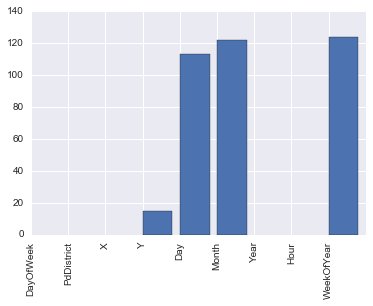

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(train[predictors], train["CategoryEncoded"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()


In [10]:

# Pick only the four best features.
predictors = ["Y", "Day", "Month","WeekOfYear"]
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

scores = cross_validation.cross_val_score(alg, train[predictors], train["CategoryEncoded"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.182044600308


In [12]:
alg.fit(train[predictors], train['CategoryEncoded'])
test['predictions'] = alg.predict(test[predictors])
test['Category'] = category_encoder.inverse_transform(test['predictions'])

test.tail()


,Id,Dates,DayOfWeek,PdDistrict,X,Y,Day,Month,Year,Hour,Minute,WeekOfYear,predictions,Category
884257,884257,2003-01-01 00:01:00,2,3,-122.408983,37.751987,1,1,2003,0,1,1,1,ASSAULT
884258,884258,2003-01-01 00:01:00,2,4,-122.425342,37.792681,1,1,2003,0,1,1,16,LARCENY/THEFT
884259,884259,2003-01-01 00:01:00,2,2,-122.445418,37.712075,1,1,2003,0,1,1,36,VEHICLE THEFT
884260,884260,2003-01-01 00:01:00,2,0,-122.387394,37.739479,1,1,2003,0,1,1,21,OTHER OFFENSES
884261,884261,2003-01-01 00:01:00,2,8,-122.489714,37.733950,1,1,2003,0,1,1,21,OTHER OFFENSES


In [14]:

y = train['Category'].astype('category')
submit = pd.DataFrame({'Id': test.Id.tolist()})
for category in y.cat.categories:
    submit[category] = np.where(test.Category == category, 1, 0)
submit.to_csv('kaggle_random_forest.csv', index = False)